Find motifs! (Repeated seqs)

In [3]:
#code written with Chat GPT
#idea by Hyeonje Yang

from collections import defaultdict

def find_exact_repeats(fasta_chunk, min_len=3, max_len=10, min_reps=2):

    lines = fasta_chunk.strip().splitlines()
    header = None
    seq_lines = []

    # FASTA 헤더/서열 분리
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if line.startswith(">"):
            header = line[1:].strip()
        else:
            seq_lines.append(line)
    sequence = "".join(seq_lines).replace(" ", "").upper()

    motifs = defaultdict(lambda: {"count": 0, "positions": []})

    for L in range(min_len, max_len + 1):
        for j in range(0, len(sequence) - L + 1):
            motif = sequence[j:j + L]
            motifs[motif]["count"] += 1
            motifs[motif]["positions"].append(j)

    filtered = {
        m: info for m, info in motifs.items()
        if info["count"] >= min_reps
    }

    return {"header": header, "motifs": filtered}


In [4]:
from Bio import SeqIO
from io import StringIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def clean_fasta(infile):
    cleaned = []
    with open(infile) as f:
        seq_lines = []
        for line in f:
            line = line.strip()
            if not line:
                continue  # 빈 줄 무시
            if line.startswith(">"):
                if seq_lines:
                    cleaned.append("\n".join(seq_lines))
                    seq_lines = []
                cleaned.append(line)
            else:
                seq_lines.append(line)
        if seq_lines:
            cleaned.append("\n".join(seq_lines))
    return "\n".join(cleaned)

분석할 FASTA 파일 경로를 입력하세요 (.fasta):  uniprotkb_protein_name_ALKBH9B_2025_10_07.fasta
최소 motif 길이 (예: 3):  3
최대 motif 길이 (예: 10):  3
최소 반복 횟수 (예: 2):  3



반복서열 행렬 요약:
                                RRG  EEE  PLP  RFS  FSE  SPR  FLS  TQN  SEP  \
sp|Q9SL49|AKB9B_ARATH             3    7    3    0    0    0    0    0    0   
tr|A0A1S2Y3M6|A0A1S2Y3M6_CICAR    0    0    0    3    3    3    3    3    3   
tr|A0A6I9QR56|A0A6I9QR56_ELAGV    0    0    0    0    0    0    0    0    0   
tr|A0A6I9RYY6|A0A6I9RYY6_ELAGV    0    9    3    0    0    0    0    0    3   
tr|A0A6J0MD87|A0A6J0MD87_RAPSA    0    3    0    0    0    0    0    0    0   

                                EPR  ...  SWK  LGS  DDD  NSL  SLG  GSW  KIV  \
sp|Q9SL49|AKB9B_ARATH             0  ...    0    0    0    0    0    0    0   
tr|A0A1S2Y3M6|A0A1S2Y3M6_CICAR    3  ...    0    0    0    0    0    0    0   
tr|A0A6I9QR56|A0A6I9QR56_ELAGV    0  ...    0    0    0    0    0    0    0   
tr|A0A6I9RYY6|A0A6I9RYY6_ELAGV    0  ...    0    0    0    0    0    0    0   
tr|A0A6J0MD87|A0A6J0MD87_RAPSA    0  ...    0    0    0    0    0    0    0   

                                ELK  

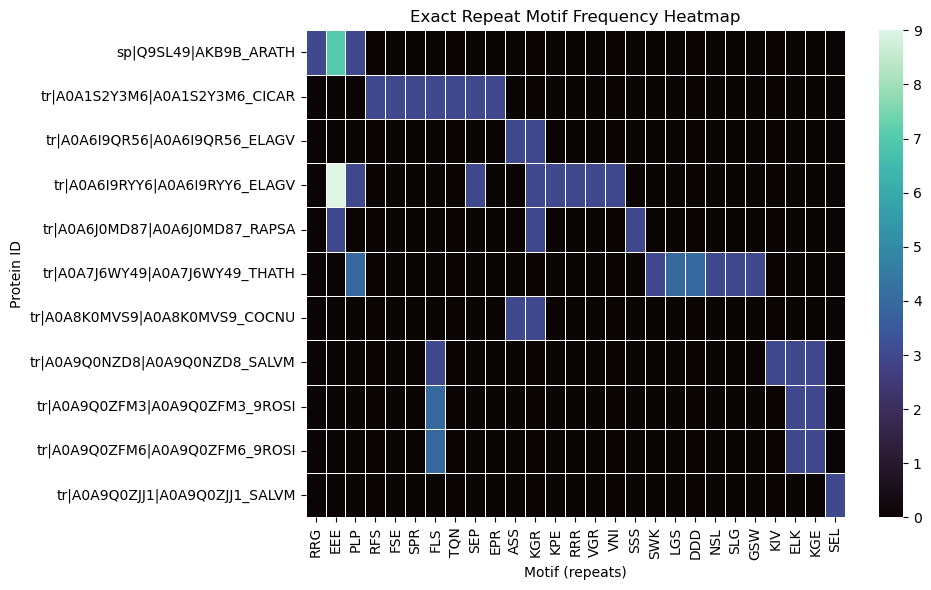

CSV 파일로 저장할까요? (y/n):  n


In [5]:
#Get repeated seqs
def getrep(sequence, min_len=3, max_len=10, min_reps=2):
    """
    sequence: 분석할 아미노산 서열 (string)
    min_len: 최소 motif 길이
    max_len: 최대 motif 길이
    min_reps: 최소 반복 횟수
    """
    sequence = sequence.replace("\n", "").strip()
    count_dict = {}
    
    for length in range(min_len, max_len + 1):
        motifs = []
        for i in range(0, len(sequence) - length + 1):
            motif = sequence[i:i + length]
            motifs.append(motif)
        unique = set(motifs)
        for motif in unique:
            c = motifs.count(motif)
            if c >= min_reps:
                count_dict[motif] = c
    return count_dict

#Processing...
def process_fasta_to_matrix(infile, min_len=3, max_len=10, min_reps=2):
    fasta_text = clean_fasta(infile)
    fasta_io = StringIO(fasta_text)
    all_data = []

    for record in SeqIO.parse(fasta_io, "fasta"):
        seq = str(record.seq)
        repeat_counts = getrep(seq, min_len, max_len, min_reps)
        if repeat_counts:  # 반복이 하나라도 있으면
            df = pd.DataFrame([repeat_counts], index=[record.id])
            all_data.append(df)
    if not all_data:
        print("반복서열을 찾지 못했습니다. 조건을 완화해보세요.")
        return None
    matrix = pd.concat(all_data).fillna(0).astype(int)
    return matrix

#heatmap
def visualize_matrix(matrix, title="Exact Repeat Motif Frequency Heatmap"):
    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix, cmap="mako", linewidths=0.5)
    plt.xlabel("Motif (repeats)")
    plt.ylabel("Protein ID")
    plt.title(title)
    plt.tight_layout()
    plt.show()

#write the path of the fasta file
if __name__ == "__main__":
    fasta_file = input("분석할 FASTA 파일 경로를 입력하세요 (.fasta): ").strip()
    min_len = int(input("최소 motif 길이 (예: 3): "))
    max_len = int(input("최대 motif 길이 (예: 10): "))
    min_reps = int(input("최소 반복 횟수 (예: 2): "))

    matrix = process_fasta_to_matrix(fasta_file, min_len, max_len, min_reps)
    if matrix is not None:
        print("\n반복서열 행렬 요약:")
        print(matrix.head())
        visualize_matrix(matrix)
        save = input("CSV 파일로 저장할까요? (y/n): ").strip().lower()
        if save == "y":
            matrix.to_csv("repeat_matrix.csv")
            print("'repeat_matrix.csv'로 저장 완료!")

#example
#uniprotkb_protein_name_ALKBH9B_2025_10_07.fasta